<a href="https://colab.research.google.com/github/nfahrisalim/TikTokCyberBullying/blob/main/Cyberbullying_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [55]:
!pip install indoNLP
!pip install sastrawi
!pip install tensorflow

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from indoNLP.preprocessing import *
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory, StopWordRemover, ArrayDictionary
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import model_selection
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, classification_report
from sklearn.utils import resample
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
import joblib

In [3]:
url = 'https://github.com/nfahrisalim/TikTokCyberBullying/raw/main/tiktokscraped.csv'
df = pd.read_csv(url)

df


,text,label
0,1 detik langsung habis sih,0
1,1 notif 1 menit belajar moai melipat tangan wa...,0
2,1 ribu dolar 1 miliar lebih wajah gembira beru...,0
3,1 tahun tanpa figur seorang ayah itu sangat be...,0
4,10 10 bagi aku,0
...,...,...
12187,"""banyak kali bah oranh yang mau digaji 700perak🌚""",1
12188,"""tanpa mahasiswa Kaesang jadi gubernur hahahaha""",1
12189,"""MANA MANA? PEDUKUNG OKE GAS OKE GAS 🤪😹""",1
12190,"""bentar lagi masuk pkb apa pdi nih""",1


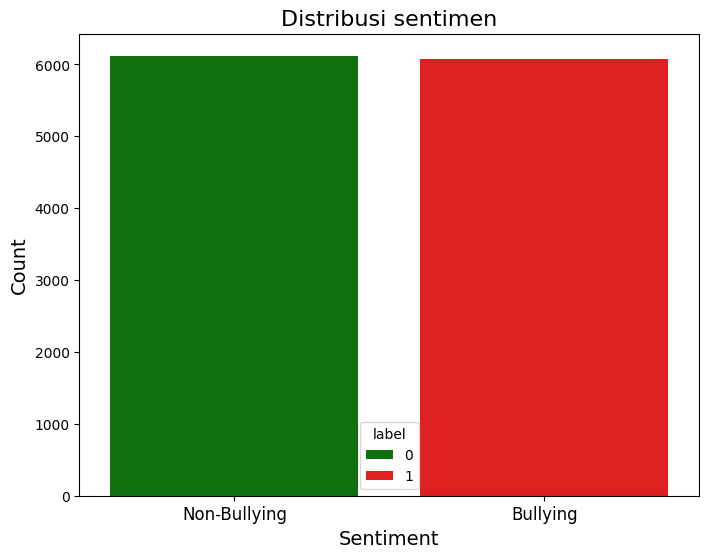

In [4]:
sentiment_counts = df['label'].value_counts().reset_index()
sentiment_counts.columns = ['label', 'Count']

plt.figure(figsize=(8, 6))
sns.barplot(x='label', y='Count', data=sentiment_counts, hue='label', dodge=False, palette=['green', 'red'])
plt.title('Distribusi sentimen', fontsize=16)
plt.xlabel('Sentiment', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(ticks=[0, 1], labels=['Non-Bullying', 'Bullying'], fontsize=12)
plt.show()

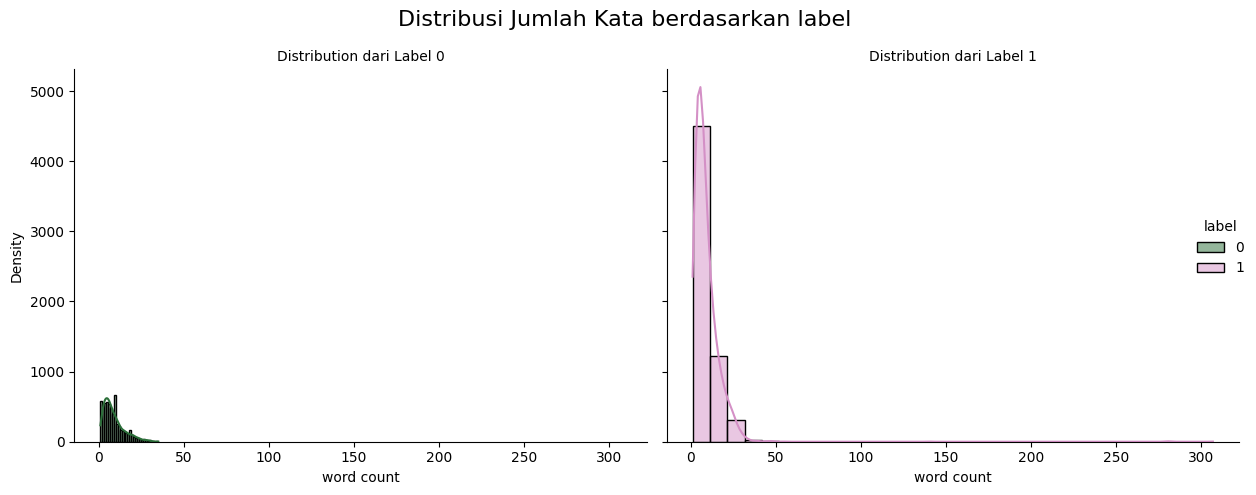

In [5]:
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

g = sns.FacetGrid(df, col='label', hue='label', palette='cubehelix', height=5, aspect=1.2)
g.map(sns.histplot, 'word_count', kde=True, bins=30)

g.set_axis_labels("word count", "Density")
g.set_titles("Distribution dari Label {col_name}")
g.fig.suptitle("Distribusi Jumlah Kata berdasarkan label", fontsize=16)
g.add_legend()
plt.tight_layout()
plt.show()

In [6]:
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))

df.groupby('label')['word_count'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
0,6122.0,8.746651,6.118073,1.0,4.0,7.0,12.0,35.0
1,6070.0,9.004283,9.729984,1.0,4.0,7.0,12.0,307.0


In [7]:
max_len = 35

df['text'] = df['text'].apply(lambda x: ' '.join(str(x).split()[:max_len]))
df['word_count'] = df['text'].apply(lambda x: len(str(x).split()))


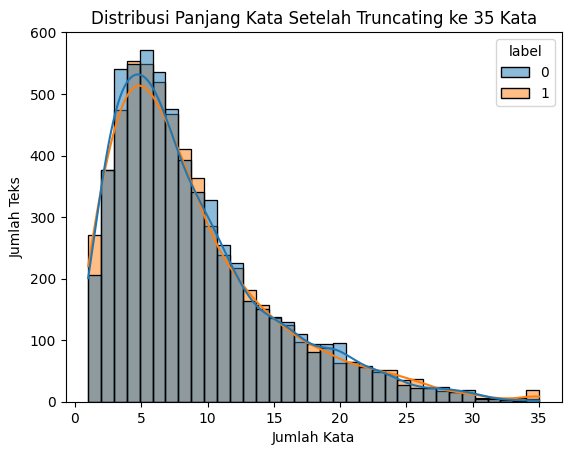

In [8]:
sns.histplot(data=df, x='word_count', hue='label', kde=True, bins=35)
plt.title("Distribusi Panjang Kata Setelah Truncating ke 35 Kata")
plt.xlabel("Jumlah Kata")
plt.ylabel("Jumlah Teks")
plt.show()

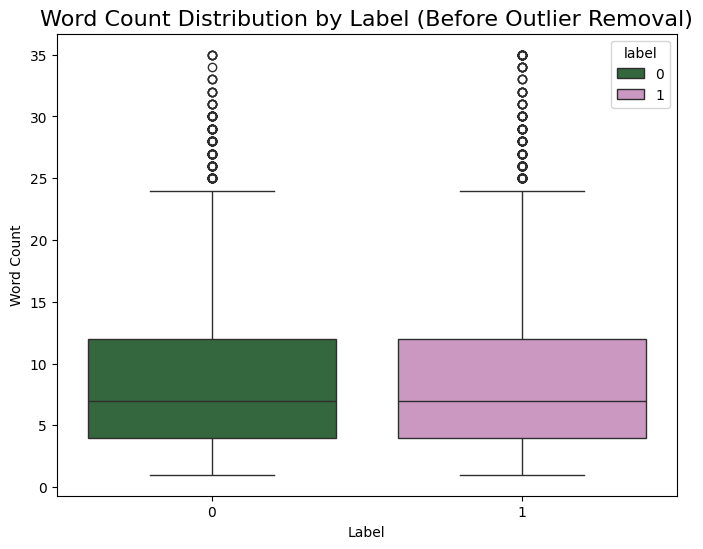

In [9]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='label', y='word_count', data=df, palette='cubehelix', hue='label')
plt.title('Word Count Distribution by Label (Before Outlier Removal)', fontsize=16)
plt.xlabel('Label')
plt.ylabel('Word Count')
plt.show()

In [10]:
df

,text,label,word_count
0,1 detik langsung habis sih,0,5
1,1 notif 1 menit belajar moai melipat tangan wa...,0,12
2,1 ribu dolar 1 miliar lebih wajah gembira beru...,0,11
3,1 tahun tanpa figur seorang ayah itu sangat be...,0,10
4,10 10 bagi aku,0,4
...,...,...,...
12187,"""banyak kali bah oranh yang mau digaji 700perak🌚""",1,8
12188,"""tanpa mahasiswa Kaesang jadi gubernur hahahaha""",1,6
12189,"""MANA MANA? PEDUKUNG OKE GAS OKE GAS 🤪😹""",1,8
12190,"""bentar lagi masuk pkb apa pdi nih""",1,7


In [11]:
df.duplicated(subset=['text']).sum()

np.int64(162)

In [12]:
df.drop_duplicates(inplace=True, subset=['text'])

In [13]:
def convert_emoji(text) :
    return emoji_to_words(text, lang='id', use_alias=False, delimiter=(' ', ' '))

df['text'] = df['text'].apply(convert_emoji)


In [14]:
#Bersihin data ( remove simbol, emoji etc)
def clean_text(text):
    text = re.sub(r'http\S+', '', text) #remove url
    text = re.sub(r'@\S+', '', text) #remove mention
    text = re.sub(r'#\S+', '', text) #remove hashtag
    text = re.sub(r'[^A-Za-z0-9]+', ' ', text) #keep only alphanumeric
    text = re.sub(r'\s+', ' ', text).strip() #remove extra spaces
    text = re.sub(r'(.)\1+', r'\1', text) #remove duplicate characters

    return text

In [15]:
df['text'] = df['text'].apply(clean_text)
df['text'] = df['text'].str.lower()

In [16]:
df['text_cleaned'] = df['text'].apply(lambda x: replace_slang(x))

In [17]:
stop_words = StopWordRemoverFactory().get_stop_words()

new_array = ArrayDictionary(stop_words)
stop_words_remover_new = StopWordRemover(new_array)

def stopword(str_text):
  str_text = stop_words_remover_new.remove(str_text)
  return str_text

df['text_cleaned'] = df['text_cleaned'].apply(lambda x: stopword(x))

In [18]:
def tokenize_text(text):
    return text.split()

df['text_cleaned'] = df['text_cleaned'].apply(tokenize_text)

In [19]:
def stemming(text_cleaning):
  factory = StemmerFactory()
  stemmer = factory.create_stemmer()
  do = []
  for w in text_cleaning:
    dt = stemmer.stem(w)
    do.append(dt)
  d_clean = []
  d_clean = " ".join(do)
  return d_clean

df['text_cleaned'] = df['text_cleaned'].apply(lambda x: stemming(x))

In [20]:
df.sample(10)

,text,label,word_count,text_cleaned
5788,yng di p guagada yang nge waifu in samsek,0,9,di p guagada nge waifu samsek
10442,tidak mandi wajah menangis keras aku teknik lo,1,5,mandi wajah menang keras aku teknik lo
8719,nama lu ganti noh jangan nama indonesia hus hus,1,9,nama lu ganti noh jangan nama indonesia hus hus
9119,piatu,1,1,piatu
2586,mentri pendidikan yg bersih pak anies,0,6,tri didik bersih pak anies
10950,yg ngehina abang nya kelihatan banget adab dia...,1,10,hina abang nya lihat banget adab ajar orang tu...
4923,wah wah para nitizen yg sempurna,0,6,wah wah nitizen sempurna
10563,i sih pake duit buat joki tugas moai,1,7,i sih pakai duit buat joki tugas moa
2859,orang mana sih dia,0,4,orang mana sih
11000,bro trlalu ktmu dark system smpe ketmu yg bias...,1,13,bro terlalu ketemu dark system ketmu biasa di ...


In [21]:
df['cleaned word count'] = df['text_cleaned'].apply(lambda x: len(x.split()))

<Axes: xlabel='cleaned word count', ylabel='Count'>

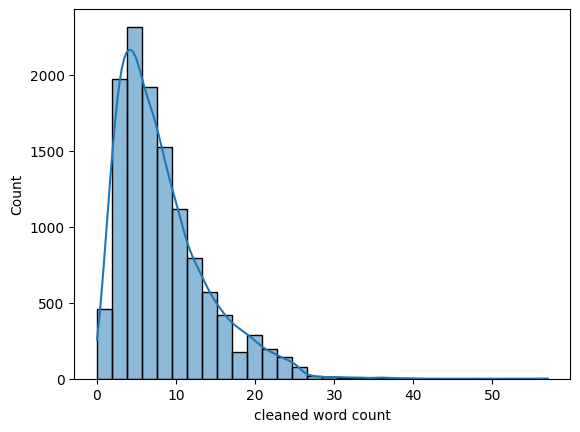

In [22]:
sns.histplot(df['cleaned word count'], kde=True, bins=30)

In [23]:
Q1 = df['cleaned word count'].quantile(0.25)
Q3 = df['cleaned word count'].quantile(0.75)
IQR = Q3 - Q1

outliers = df[(df['cleaned word count'] < (Q1 - 1.5 * IQR)) | (df['cleaned word count'] > (Q3 + 1.5 * IQR))]
outliers['cleaned word count'].describe()

,cleaned word count
count,375.000000
mean,24.981333
std,4.363457
min,22.000000
25%,23.000000
50%,24.000000
75%,25.000000
max,57.000000


In [24]:
df['cleaned word count'].describe()

,cleaned word count
count,12030.000000
mean,8.169493
std,5.621484
min,0.000000
25%,4.000000
50%,7.000000
75%,11.000000
max,57.000000


In [25]:
print('Jumlah teks dengan lebih dari 25 kata:', df[df['cleaned word count'] > 25].shape)
print('Jumlah teks dengan 0 kata:', df[df['cleaned word count'] == 0].shape)

Jumlah teks dengan lebih dari 25 kata: (76, 5)
Jumlah teks dengan 0 kata: (3, 5)


In [26]:
df = df[(df['cleaned word count'] > 0) & (df['cleaned word count'] <= 25)]

<Axes: xlabel='cleaned word count', ylabel='Count'>

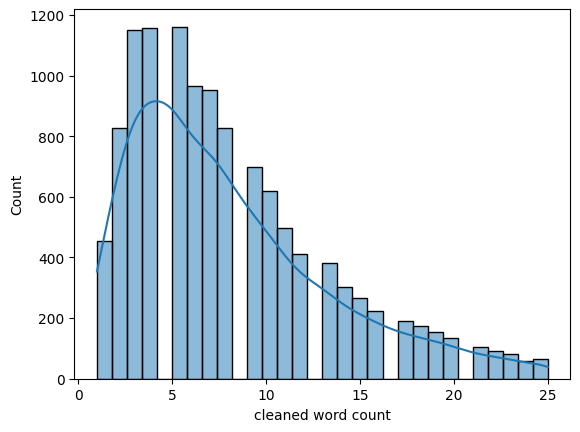

In [27]:
sns.histplot(df['cleaned word count'], kde=True, bins=30)

In [28]:
X = df['text_cleaned']
y = df['label']

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size=0.2, random_state=42)

In [29]:
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(X_train)
X_test = vectorizer.transform(X_test)

In [30]:
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Non-Bullying', 'Bullying'],
                yticklabels=['Non-Bullying', 'Bullying'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'{model_name} Confusion Matrix')
    plt.show()

Logistic Regression Accuracy Score Training -> 84.31%
Logistic Regression Accuracy Score Testing -> 72.56%
Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.74      0.73      1223
           1       0.72      0.71      0.72      1168

    accuracy                           0.73      2391
   macro avg       0.73      0.73      0.73      2391
weighted avg       0.73      0.73      0.73      2391

Logistic Regression ROC AUC Score -> 0.7252

Logistic Regression Confusion Matrix:


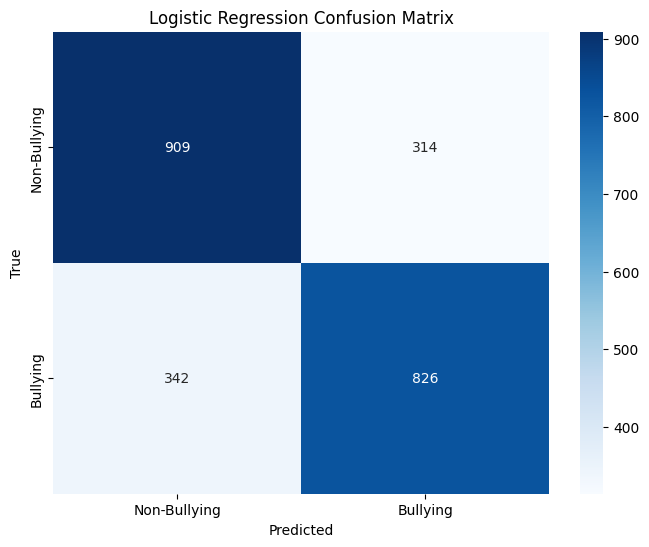

--------------------------------------------------
SVM Accuracy Score Training -> 95.82%
SVM Accuracy Score Testing -> 73.57%
SVM Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.72      0.74      1223
           1       0.72      0.75      0.73      1168

    accuracy                           0.74      2391
   macro avg       0.74      0.74      0.74      2391
weighted avg       0.74      0.74      0.74      2391

SVM ROC AUC Score -> 0.7360

SVM Confusion Matrix:


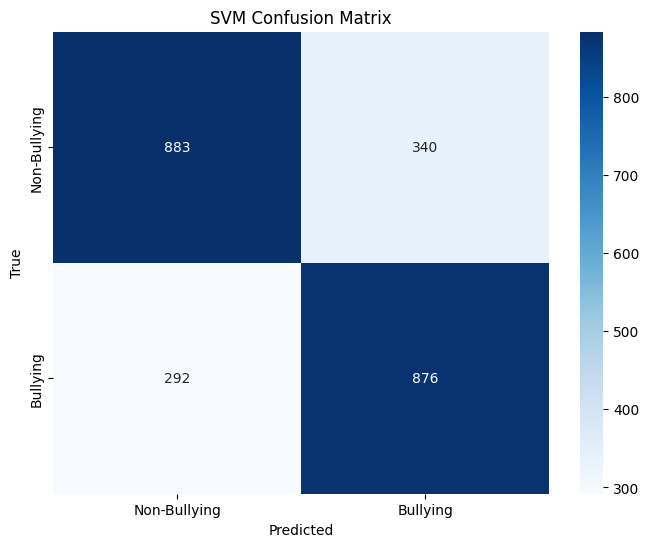

--------------------------------------------------
Naive Bayes Accuracy Score Training -> 86.11%
Naive Bayes Accuracy Score Testing -> 73.36%
Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.71      0.73      1223
           1       0.71      0.76      0.73      1168

    accuracy                           0.73      2391
   macro avg       0.73      0.73      0.73      2391
weighted avg       0.73      0.73      0.73      2391

Naive Bayes ROC AUC Score -> 0.7341

Naive Bayes Confusion Matrix:


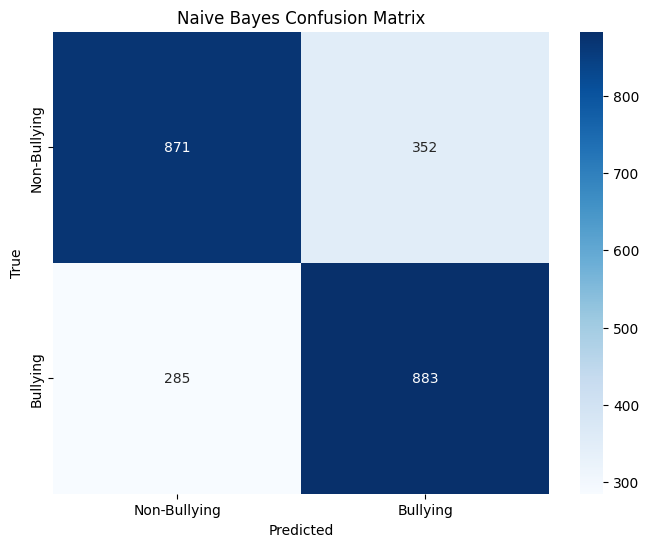

--------------------------------------------------


In [31]:
def train_and_evaluate_model(model, model_name):
    model.fit(X_train, y_train)

    predictions_train = model.predict(X_train)
    predictions_test = model.predict(X_test)

    train_accuracy = accuracy_score(y_train, predictions_train) * 100
    test_accuracy = accuracy_score(y_test, predictions_test) * 100

    print(f"{model_name} Accuracy Score Training -> {train_accuracy:.2f}%")
    print(f"{model_name} Accuracy Score Testing -> {test_accuracy:.2f}%")

    print(f"{model_name} Classification Report:")
    print(classification_report(y_test, predictions_test))

    roc_auc = roc_auc_score(y_test, predictions_test)
    print(f"{model_name} ROC AUC Score -> {roc_auc:.4f}\n")

    print(f"{model_name} Confusion Matrix:")
    plot_confusion_matrix(y_test, predictions_test, model_name)

    print('-' * 50)
    return model

# Existing models
logistic_regression = train_and_evaluate_model(LogisticRegression(), 'Logistic Regression')
svm = train_and_evaluate_model(SVC(), 'SVM')
naive_bayes = train_and_evaluate_model(MultinomialNB(), 'Naive Bayes')

In [32]:
from sklearn.model_selection import GridSearchCV

param_grid_logreg = {
    'C': [0.1, 1, 10, 100],
    'max_iter': [100, 200, 300, 400],
    'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
    'penalty': ['l1', 'l2']
}

grid_search_logistic = GridSearchCV(LogisticRegression(), param_grid_logreg, cv=5, n_jobs=-1, scoring='roc_auc', verbose= 1)
grid_search_logistic.fit(X_train, y_train)

print(f"Best Parameters: {grid_search_logistic.best_params_}")
print(f"Best Score: {grid_search_logistic.best_score_}")

Fitting 5 folds for each of 160 candidates, totalling 800 fits
Best Parameters: {'C': 1, 'max_iter': 200, 'penalty': 'l2', 'solver': 'saga'}
Best Score: 0.7861360174864461


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py:528: FitFailedWarning: 
240 fits failed out of a total of 800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
80 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py", line 1193, in fit
    solver = _check_solv

Best Logistic Regression (GridSearch) Accuracy Score Training -> 84.32%
Best Logistic Regression (GridSearch) Accuracy Score Testing -> 72.44%
Best Logistic Regression (GridSearch) Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.74      0.73      1223
           1       0.72      0.71      0.72      1168

    accuracy                           0.72      2391
   macro avg       0.72      0.72      0.72      2391
weighted avg       0.72      0.72      0.72      2391

Best Logistic Regression (GridSearch) ROC AUC Score -> 0.7241

Best Logistic Regression (GridSearch) Confusion Matrix:


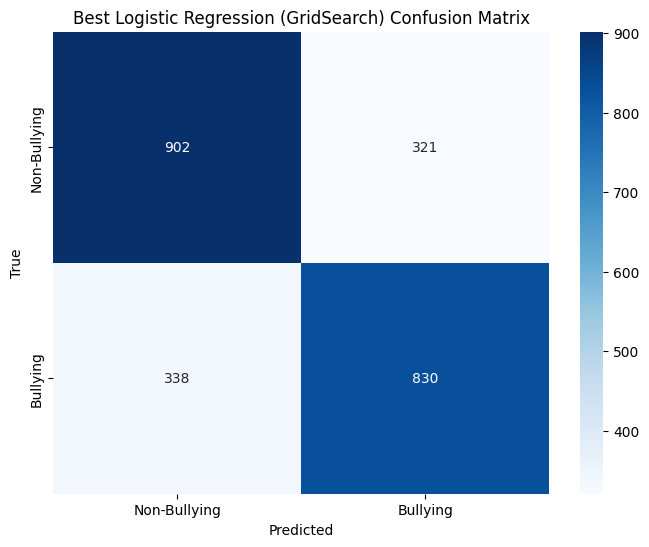

--------------------------------------------------


In [33]:
best_logistic_regression = grid_search_logistic.best_estimator_
best_logistic_regression = train_and_evaluate_model(best_logistic_regression, 'Best Logistic Regression (GridSearch)')

In [34]:
param_grid_svm = {
    'C': [0.1, 1, 10, 100],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'degree': [2, 3, 4],  # Degree only relevant for 'poly' kernel
    'gamma': ['scale', 'auto'],  # Gamma parameter for 'rbf', 'poly', and 'sigmoid' kernels
    'coef0': [0.0, 0.1, 0.5],  # coef0 parameter for 'poly' and 'sigmoid' kernels
}

grid_search_svm = GridSearchCV(SVC(), param_grid_svm, cv=5, n_jobs=-1, scoring='roc_auc', verbose=1)
grid_search_svm.fit(X_train, y_train)

print(f"Best Parameters: {grid_search_svm.best_params_}")
print(f"Best Score: {grid_search_svm.best_score_}")

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
Best Parameters: {'C': 1, 'coef0': 0.1, 'degree': 2, 'gamma': 'scale', 'kernel': 'poly'}
Best Score: 0.7895970406315433


Best SVM (GridSearch) Accuracy Score Training -> 97.47%
Best SVM (GridSearch) Accuracy Score Testing -> 73.53%
Best SVM (GridSearch) Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.74      0.74      1223
           1       0.73      0.73      0.73      1168

    accuracy                           0.74      2391
   macro avg       0.74      0.74      0.74      2391
weighted avg       0.74      0.74      0.74      2391

Best SVM (GridSearch) ROC AUC Score -> 0.7352

Best SVM (GridSearch) Confusion Matrix:


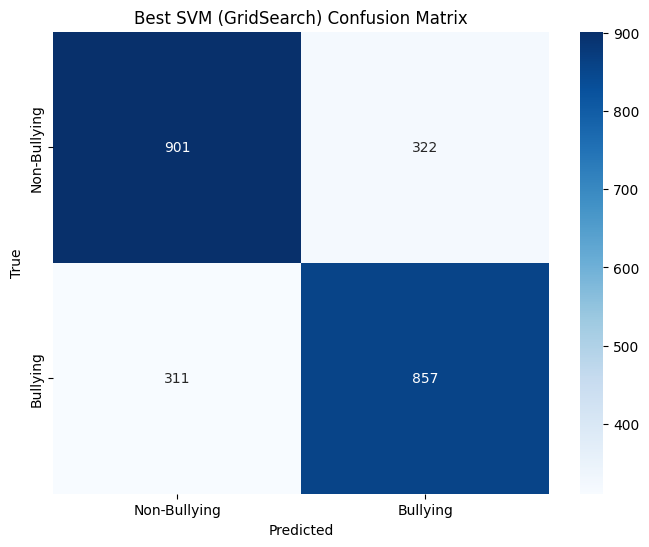

--------------------------------------------------


In [35]:
best_svm = grid_search_svm.best_estimator_
best_svm = train_and_evaluate_model(best_svm, 'Best SVM (GridSearch)')

In [36]:
param_grid_nb = {
    'alpha': [0.1, 0.5, 1.0, 2.0, 5.0]
}

grid_search_nb = GridSearchCV(MultinomialNB(), param_grid_nb, cv=5, n_jobs=-1, scoring='roc_auc', verbose=1)
grid_search_nb.fit(X_train, y_train)

print(f"Best Parameters: {grid_search_nb.best_params_}")
print(f"Best Score: {grid_search_nb.best_score_}")

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best Parameters: {'alpha': 0.5}
Best Score: 0.7995603046116659


Best Multinomial Naive Bayes Accuracy Score Training -> 87.73%
Best Multinomial Naive Bayes Accuracy Score Testing -> 73.02%
Best Multinomial Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.71      0.73      1223
           1       0.71      0.75      0.73      1168

    accuracy                           0.73      2391
   macro avg       0.73      0.73      0.73      2391
weighted avg       0.73      0.73      0.73      2391

Best Multinomial Naive Bayes ROC AUC Score -> 0.7306

Best Multinomial Naive Bayes Confusion Matrix:


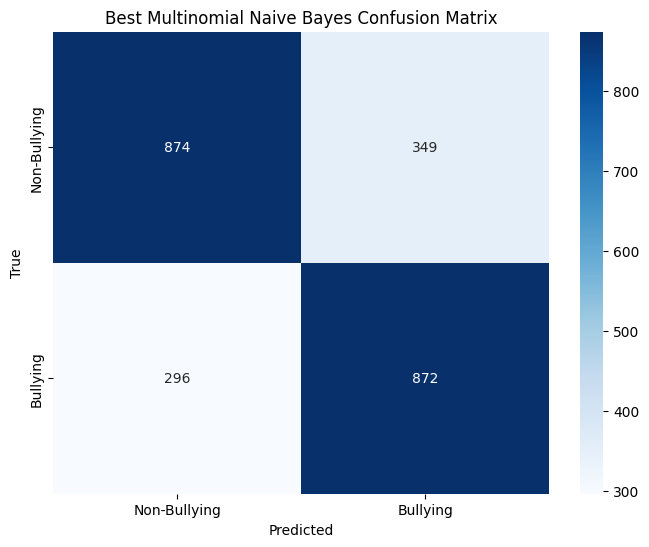

--------------------------------------------------


In [38]:
best_multinomial_nb = grid_search_nb.best_estimator_
best_multinomial_nb = train_and_evaluate_model(best_multinomial_nb, 'Best Multinomial Naive Bayes')

In [46]:
def predict_hate_speech(text, model, model_name):
    basetext = text
    text = convert_emoji(text)
    text = clean_text(text)
    text = text.lower()
    text = replace_slang(text)
    text = stopword(text)
    text = tokenize_text(text)
    text = stemming(text)
    text = vectorizer.transform([text])

    prediction = model.predict(text)
    result = 'Bullying' if prediction == 1 else 'Non Bullying'
    return f'{model_name} Prediction: {result}'

text = input('Enter text: ')
print("Prediksi yang benar adalah Bullying!")

print(predict_hate_speech(text, logistic_regression, 'Logistic Regression'))
print(predict_hate_speech(text, svm, 'SVM'))
print(predict_hate_speech(text, naive_bayes, 'Naive Bayes'))

Enter text: biasa anak anak ,anak anj
Prediksi yang benar adalah Bullying!
Logistic Regression Prediction: Bullying
SVM Prediction: Bullying
Naive Bayes Prediction: Bullying


In [47]:
df

,text,label,word_count,text_cleaned,cleaned word count
0,1 detik langsung habis sih,0,5,1 detik langsung habis sih,5
1,1 notif 1 menit belajar moai melipat tangan wa...,0,12,1 notif 1 menit ajar moa lipat tangan warna ku...,12
2,1 ribu dolar 1 miliar lebih wajah gembira beru...,0,11,1 ribu dolar 1 miliar lebih wajah gembira urai...,11
3,1 tahun tanpa figur seorang ayah itu sangat be...,0,10,1 tahun figur orang ayah sangat berat lo,8
4,10 10 bagi aku,0,4,10 10 aku,3
...,...,...,...,...,...
12187,banyak kali bah oranh yang mau digaji 70perak ...,1,8,banyak kali bah oranh mau gaji 70perak wajah b...,10
12188,tanpa mahasiswa kaesang jadi gubernur hahahaha,1,6,mahasiswa kaesang jadi gubernur hahahaha,5
12189,mana mana pedukung oke gas oke gas wajah konyo...,1,8,mana mana dukung oke gas oke gas wajah konyol ...,15
12190,bentar lagi masuk pkb apa pdi nih,1,7,bentar masuk pkb apa pdi nih,6


In [49]:
!pip install fasttext

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 2.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-2.13.6-py3-none-any.whl.metadata (9.5 kB)
Using cached pybind11-2.13.6-py3-none-any.whl (243 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp311-cp311-linux_x86_64.whl size=4313492 sha256=eb39b4ed05efbbca38e438b40d948ea299b7eef7304f04cc84d4f353ecd021ca
  Stored in directory: /root/.cache/pip/wheels/65/4f/35/5057db0249224e9ab55a513fa6b79451473ceb7713017823c3
Successfully built fasttext


In [57]:
import fasttext
sentences = df['text_cleaned'].apply(lambda x: x.split())

ft = fasttext.load_model('/content/drive/MyDrive/cc.en.300.bin')
# Embedding function
def get_word_embedding(text):
    return [ft.get_word_vector(word) for word in text]

# Apply embedding
sentence_embeddings = sentences.apply(get_word_embedding)

# Padding
max_len = 25  # Sesuaikan, lebih kecil dari 50 agar tidak terlalu banyak padding
padded_embeddings = pad_sequences(sentence_embeddings, maxlen=max_len, dtype='float32', padding='post', truncating='post')

# Convert to array
X = np.array(padded_embeddings, dtype='float32')
y = df['label'].values

In [59]:
from sklearn.utils.class_weight import compute_class_weight

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Hitung class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weight_dict = dict(enumerate(class_weights))


In [60]:
from keras.models import Sequential
from keras.layers import LSTM, Dropout, Dense, Masking

model = Sequential()
model.add(Masking(mask_value=0.0, input_shape=(max_len, 300)))  # 300 = dimensi FastText
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(64))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/masking.py:47: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [61]:
from keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    epochs=25,
    batch_size=32,
    validation_split=0.1,
    class_weight=class_weight_dict,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/25
269/269 ━━━━━━━━━━━━━━━━━━━━ 21s 64ms/step - accuracy: 0.5456 - loss: 0.6853 - val_accuracy: 0.5669 - val_loss: 0.6840
Epoch 2/25
269/269 ━━━━━━━━━━━━━━━━━━━━ 16s 61ms/step - accuracy: 0.6222 - loss: 0.6505 - val_accuracy: 0.6370 - val_loss: 0.6443
Epoch 3/25
269/269 ━━━━━━━━━━━━━━━━━━━━ 16s 58ms/step - accuracy: 0.6426 - loss: 0.6236 - val_accuracy: 0.6370 - val_loss: 0.6348
Epoch 4/25
269/269 ━━━━━━━━━━━━━━━━━━━━ 16s 58ms/step - accuracy: 0.6596 - loss: 0.6107 - val_accuracy: 0.6496 - val_loss: 0.6305
Epoch 5/25
269/269 ━━━━━━━━━━━━━━━━━━━━ 16s 58ms/step - accuracy: 0.6730 - loss: 0.5916 - val_accuracy: 0.6506 - val_loss: 0.6344
Epoch 6/25
269/269 ━━━━━━━━━━━━━━━━━━━━ 16s 58ms/step - accuracy: 0.6887 - loss: 0.5784 - val_accuracy: 0.6548 - val_loss: 0.6366
Epoch 7/25
269/269 ━━━━━━━━━━━━━━━━━━━━ 15s 57ms/step - accuracy: 0.7049 - loss: 0.5656 - val_accuracy: 0.6590 - val_loss: 0.6239
Epoch 8/25
269/269 ━━━━━━━━━━━━━━━━━━━━ 16s 59ms/step - accuracy: 0.7255 - loss: 0.5348 - 

75/75 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step
Test Accuracy: 64.53%

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.64      0.65      1223
           1       0.63      0.65      0.64      1168

    accuracy                           0.65      2391
   macro avg       0.65      0.65      0.65      2391
weighted avg       0.65      0.65      0.65      2391

ROC AUC Score: 0.7055

Confusion Matrix:


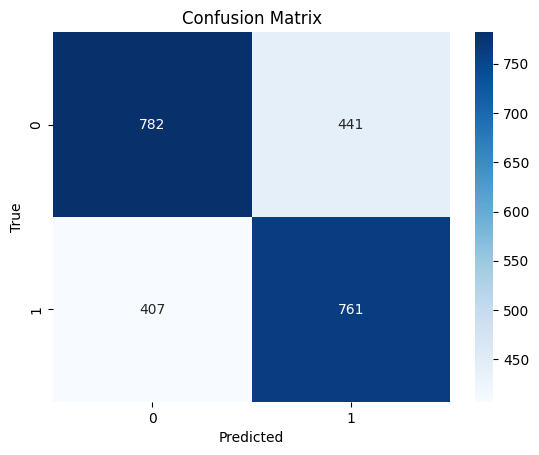

In [62]:

def plot_confusion_matrix(y_true, y_pred, title='Confusion Matrix'):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

def evaluate_model(model, X_test, y_test):
    predictions = model.predict(X_test)
    pred_labels = (predictions > 0.5).astype(int).flatten()

    acc = accuracy_score(y_test, pred_labels) * 100
    print(f"Test Accuracy: {acc:.2f}%")

    print("\nClassification Report:")
    print(classification_report(y_test, pred_labels))

    roc = roc_auc_score(y_test, predictions)
    print(f"ROC AUC Score: {roc:.4f}")

    print("\nConfusion Matrix:")
    plot_confusion_matrix(y_test, pred_labels)

evaluate_model(model, X_test, y_test)


In [73]:
#test model on user input
def predict_hate_speech(text):
    basetext = text
    text = convert_emoji(text)
    text = clean_text(text)
    text = text.lower()
    text = replace_slang(text)
    text = stopword(text)
    text = tokenize_text(text)
    text = stemming(text)

    embedding = get_word_embedding(text)
    padded_embedding = pad_sequences([embedding], maxlen=50, dtype='float32', padding='post')
    prediction = lstm.predict(padded_embedding)

    #set output as 1 or 0

    if prediction > 0.5:
        result = f'Teks ini teridentifikasi Bullying dengan confidence score {prediction[0][0]:.2f}'
    else:
        result = f'Teks ini teridentifikasi Non Bullying dengan confidence score {1 - prediction[0][0]:.2f}'
    print(f'Input : {basetext}')
    return result

text = input('Enter text: ')
print("Prediksi yang benar adalah Bullying!")

predict_hate_speech(text)

Enter text: Mulyono
Prediksi yang benar adalah Bullying!
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
Input : Mulyono


'Teks ini teridentifikasi Non Bullying dengan confidence score 0.51'

In [74]:
lstm.save('lstm_model.h5')
# Saving Models
joblib.dump(logistic_regression, 'logistic_regression_model.pkl')
joblib.dump(best_svm, 'svm_model.pkl')
joblib.dump(naive_bayes, 'naive_bayes_model.pkl')

# Saving TF-IDF Vectorizer Model
joblib.dump(vectorizer, 'vectorizer.pkl')

['vectorizer.pkl']

In [75]:
from google.colab import files

files.download('lstm_model.h5')
files.download('logistic_regression_model.pkl')
files.download('svm_model.pkl')
files.download('naive_bayes_model.pkl')
files.download('vectorizer.pkl')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>